In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.ops as ops
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import ToPILImage


# Importing machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from einops import rearrange, repeat

# Importing libraries for medical image handling and dataset setup
import os
import json
import ast
import gc
import shutil
import glob
import sys
import random
from tqdm import tqdm
from pathlib import Path
from PIL import Image

In [2]:
import transformers, huggingface_hub
print(transformers.__version__, huggingface_hub.__version__)

/blue/cruzcastrol/dthiyagarajan/.conda/envs/eoi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.57.1 0.36.0


In [3]:
os.environ["TRANSFORMERS_NO_ADDITIONAL_CHAT_TEMPLATES"] = "1"

In [4]:
from transformers import RobertaModel, RobertaTokenizer, BertTokenizer
from transformers import BertModel

In [5]:
root_directory = os.path.dirname(os.path.dirname(os.getcwd()))

In [6]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
captions_2014_path = root_directory + "/share/dthiyagarajan/extracted_files/annotations_trainval2014/annotations/captions_train2014.json"
captions_2017_path = root_directory + "/share/dthiyagarajan/extracted_files/annotations_trainval2017/annotations/captions_val2017.json"

# Load JSON
with open(captions_2014_path, "r") as f:
    captions_2014 = json.load(f)

with open(captions_2017_path, "r") as f:
    captions_2017 = json.load(f)

# Convert to DataFrames
df_captions_2014 = pd.DataFrame(captions_2014["annotations"])
df_captions_2017 = pd.DataFrame(captions_2017["annotations"])

print("Train 2014 captions:", df_captions_2014.shape)
print("Val 2017 captions:", df_captions_2017.shape)
print("\nSample caption:\n", df_captions_2017['caption'].iloc[0])

Train 2014 captions: (414113, 3)
Val 2017 captions: (25014, 3)

Sample caption:
 A black Honda motorcycle parked in front of a garage.


In [7]:
image_dir_2014 = root_directory + "/share/dthiyagarajan/extracted_files/train2014/train2014"
image_dir_2017 = root_directory + "/share/dthiyagarajan/extracted_files/val2017/val2017"

In [8]:
df_captions_2014['source_dir'] = image_dir_2014
df_captions_2017['source_dir'] = image_dir_2017

In [9]:
df_captions_2014['image_id'] = (
    'COCO_train2014_' + df_captions_2014['image_id'].astype(str).str.zfill(12)
)

df_captions_2017['image_id'] = (
    df_captions_2017['image_id'].astype(str).str.zfill(12)
)

In [10]:
pd.set_option('display.max_colwidth', None)

In [11]:
df_captions_2014['source_dir']

0         /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
1         /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
2         /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
3         /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
4         /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
                                          ...                                  
414108    /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
414109    /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
414110    /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
414111    /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
414112    /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
Name: source_dir, Length: 414113, dtype: object

In [12]:
df_coco_unified = pd.concat([df_captions_2014, df_captions_2017], ignore_index=True)
df_coco_unified = df_coco_unified[['image_id', 'caption','source_dir']]
df_coco_unified['source'] = 'COCO'

# Rename 'image_id' for consistency if you plan to combine with Flickr, 
# although image access will differ (COCO uses 'image_id' to format the filename).
df_coco_unified.rename(columns={'image_id': 'unique_image_identifier'}, inplace=True)
df_coco_unified['unique_image_identifier'] = df_coco_unified['unique_image_identifier'].astype(str)

In [13]:
df_coco_unified.head()

unique_image_identifier  \
0  COCO_train2014_000000318556   
1  COCO_train2014_000000116100   
2  COCO_train2014_000000318556   
3  COCO_train2014_000000116100   
4  COCO_train2014_000000379340   

                                                       caption  \
0               A very clean and well decorated empty bathroom   
1     A panoramic view of a kitchen and all of its appliances.   
2  A blue and white bathroom with butterfly themed wall tiles.   
3               A panoramic photo of a kitchen and dining room   
4    A graffiti-ed stop sign across the street from a red car    

                                                              source_dir  \
0  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014   
1  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014   
2  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014   
3  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014   
4  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014   

  source  
0   COCO  
1   COCO  
2   COCO  
3   COCO  
4   COCO

In [14]:
flickr_annotations_path = root_directory + "/share/dthiyagarajan/extracted_files/flickr30k_images/results.csv"
flickr_image_path = root_directory + "/share/dthiyagarajan/extracted_files/flickr30k_images/flickr30k_images"

In [15]:
df_flickr = pd.read_csv(flickr_annotations_path, delimiter = '|')
df_flickr['source_dir'] = flickr_image_path
df_flickr.columns

Index(['image_name', ' comment_number', ' comment', 'source_dir'], dtype='object')

In [16]:

try:
    # Use the column names and delimiter identified in our previous steps
    df_flickr = pd.read_csv(
        flickr_annotations_path,
        delimiter='|',
        names=['image_name', 'comment_number', 'caption'],
        header=None,
        encoding='utf-8',
        skiprows=1 
    )
    df_flickr['source_dir'] = flickr_image_path
    # Flickr image names are already unique strings (e.g., '1000092795.jpg')
    df_flickr = df_flickr[['image_name', 'caption','source_dir']]
    df_flickr.rename(columns={'image_name': 'unique_image_identifier'}, inplace=True)
    df_flickr['source'] = 'Flickr'
except Exception as e:
    print(f"Error loading Flickr CSV: {e}. Using a small dummy set for Flickr.")
    df_flickr = pd.DataFrame({
        'unique_image_identifier': ['dummy1.jpg', 'dummy2.jpg'],
        'caption': ['A placeholder image.', 'Another example sentence.'],
        'source': 'Flickr'
    })

In [17]:
df_combined = pd.concat([df_coco_unified, df_flickr], ignore_index=True)

print("Combined DataFrame Shape:", df_combined.shape)
print("Combined Data Sources:\n", df_combined['source'].value_counts())
print("Combined DataFrame Head:")
print(df_combined[df_combined['source_dir'].str.contains('2014', na=False)].head())

Combined DataFrame Shape: (598042, 4)
Combined Data Sources:
 source
COCO      439127
Flickr    158915
Name: count, dtype: int64
Combined DataFrame Head:
       unique_image_identifier  \
0  COCO_train2014_000000318556   
1  COCO_train2014_000000116100   
2  COCO_train2014_000000318556   
3  COCO_train2014_000000116100   
4  COCO_train2014_000000379340   

                                                       caption  \
0               A very clean and well decorated empty bathroom   
1     A panoramic view of a kitchen and all of its appliances.   
2  A blue and white bathroom with butterfly themed wall tiles.   
3               A panoramic photo of a kitchen and dining room   
4    A graffiti-ed stop sign across the street from a red car    

                                                              source_dir  \
0  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014   
1  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014   
2  /blue/eee6778

In [18]:
from sklearn.model_selection import train_test_split

# 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df_combined, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(len(train_df), len(val_df), len(test_df))


478433 59804 59805


In [19]:
train_df['source_dir']

52151                   /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
595847    /blue/eee6778/share/dthiyagarajan/extracted_files/flickr30k_images/flickr30k_images
514118    /blue/eee6778/share/dthiyagarajan/extracted_files/flickr30k_images/flickr30k_images
160750                  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
477213    /blue/eee6778/share/dthiyagarajan/extracted_files/flickr30k_images/flickr30k_images
                                                 ...                                         
110268                  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
259178                  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
365838                  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
131932                  /blue/eee6778/share/dthiyagarajan/extracted_files/train2014/train2014
121958                  /blue/eee6778/share/dthiyagarajan/ex

In [20]:
# --- Configuration ---
MAX_LEN = 128 # Fixed sequence length for the Transformer input
BERT_MODEL = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
bert_model.to(device)

# --- 1. Tokenization Function (adapted from previous step) ---
def prepare_caption_for_roberta(caption, tokenizer, max_len):
    """Tokenizes a caption using RoBERTa's subword tokenizer."""
    # 'comment' is the raw string caption from the DataFrame
    encoding = tokenizer.encode_plus(
        str(caption),
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    # Squeeze(0) converts (1, MAX_LEN) to (MAX_LEN)
    return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0)

# --- 2. Custom PyTorch Dataset ---
class TextToImageDataset(Dataset):
    def __init__(self, df_combined, tokenizer, max_len, transform=None):
        self.data = df_combined
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
    
        # Text encoding
        input_ids, attention_mask = prepare_caption_for_roberta(row['caption'], self.tokenizer, self.max_len)
        #input_ids = input_ids.to(device)           # remove unsqueeze(0)
        #attention_mask = attention_mask.to(device)

        #with torch.no_grad():
            #outputs = bert_model(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
            #text_embedding = outputs.last_hidden_state.squeeze(0)
        # Image loading
        img_name = row['unique_image_identifier'] + ('.jpg' if '.' not in row['unique_image_identifier'] else '')
        img_dir = row['source_dir']
        img_path = img_dir + '/' + img_name
    
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: Image not found at {img_path}")
            image = Image.new('RGB', (256, 256), color='black')
    
        if self.transform:
            image = self.transform(image)
    
        return image, input_ids, attention_mask


In [21]:
image_transforms = T.Compose([
    T.Resize((256, 256)), # Target size for the VAE
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = TextToImageDataset(train_df, tokenizer, MAX_LEN, image_transforms)
val_dataset   = TextToImageDataset(val_df, tokenizer, MAX_LEN, image_transforms)
test_dataset  = TextToImageDataset(test_df, tokenizer, MAX_LEN, image_transforms)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 478433
Val samples: 59804
Test samples: 59805


# Encoder(Image) --> Decoder (z, Text)

In [36]:
class CrossAttention(nn.Module):
    def __init__(self, dim, context_dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        
        self.query = nn.Linear(dim, dim)
        self.key   = nn.Linear(context_dim, dim)
        self.value = nn.Linear(context_dim, dim)
        self.proj  = nn.Linear(dim, dim)
        
    def forward(self, x, context):
        B, N, C = x.shape  # image tokens
        _, M, D = context.shape  # text tokens

        q = self.query(x)
        #print(q.shape, 'query shape')
        k = self.key(context)
        #print(k.shape, 'key shape')
        v = self.value(context)
        #print(v.shape, 'after value shape')

        q = q.view(B, N, self.num_heads, C//self.num_heads).transpose(1,2)
        k = k.view(B, M, self.num_heads, C//self.num_heads).transpose(1,2)
        v = v.view(B, M, self.num_heads, C//self.num_heads).transpose(1,2)
        #print(q.shape, k.shape, v.shape)
        attn = (q @ k.transpose(-2, -1)) / (C**0.5)
        attn = attn.softmax(dim=-1)
        #print(attn.shape, 'attention shape')
        out = attn @ v
        out = out.transpose(1,2).reshape(B, N, C)
        #print(out.shape,'out shape')
        return self.proj(out)

In [37]:
class TextConditionedDecoder(nn.Module):
    def __init__(self, latent_dim=4, hidden_dim=256, text_dim=768):
        super().__init__()

        self.initial_conv = nn.Conv2d(latent_dim, hidden_dim, 3, padding=1)

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, hidden_dim//2, kernel_size = 4, stride = 2, padding=1),
            nn.GroupNorm(8, hidden_dim//2),
            nn.SiLU(),
        )
        self.cross1 = CrossAttention(hidden_dim, text_dim)

        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim//2, hidden_dim//4, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dim//4),
            nn.SiLU(),
        )
        self.cross2 = CrossAttention(hidden_dim//2, text_dim)

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim//4, hidden_dim//8, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dim//8),
            nn.SiLU(),
        )
        
        self.cross3 = CrossAttention(hidden_dim//4, text_dim)

        self.final_conv = nn.Conv2d(hidden_dim//8, 3, 3, padding=1)

    def forward(self, z, text_emb):
        # z: (B, 4, H/8, W/8)
        B, C, H, W = z.shape
        x = self.initial_conv(z)
        #print(x.shape,'after initial conv')
        # Tokenize spatial map for cross-attention
        x_tokens = x.flatten(2).transpose(1,2)  # (B, HW, C)
        #print(x_tokens.shape, 'after flatten')
        x_tokens = x_tokens + self.cross1(x_tokens, text_emb)
        #print(x_tokens.shape, 'after one cross')
        x = x_tokens.transpose(1,2).reshape(B, -1, H, W)
        #print(x.shape, 'after transpose and reshape')
        x = self.block1(x)
        #print(x.shape, 'after block1')

        x_tokens = x.flatten(2).transpose(1,2)
        #print(x_tokens.shape, 'after flatten 2')
        x_tokens = x_tokens + self.cross2(x_tokens, text_emb)
        #print(x_tokens.shape, 'after cross2')
        x = x_tokens.transpose(1,2).reshape(B, -1, H*2, W*2)
        #print(x.shape, 'after transpose and reshape')
        x = self.block2(x)
        #print(x.shape,'after block2')


        H, W = x.shape[2], x.shape[3]
        x_tokens = x.flatten(2).transpose(1,2)
        x_tokens = x_tokens + self.cross3(x_tokens, text_emb)
        x = x_tokens.transpose(1,2).reshape(B, -1, H, W)
        x = self.block3(x)  # -> 256x256
        #print(x.shape, 'final block shape')
        return torch.sigmoid(self.final_conv(x))


In [38]:
class VAEEncoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=4, hidden_dim=256):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim//2, 3, stride=2, padding=1),  # 256→128
            nn.GroupNorm(8, hidden_dim//2),
            nn.SiLU(),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_dim//2, hidden_dim, 3, stride=2, padding=1),    # 128→64
            nn.GroupNorm(8, hidden_dim),
            nn.SiLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),      # 64→32
            nn.GroupNorm(8, hidden_dim),
            nn.SiLU(),
        )

        # Final conv layers before producing mean & logvar
        self.conv_out = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.GroupNorm(8, hidden_dim),
            nn.SiLU(),
        )

        # Mean and log-variance projection heads
        self.to_mean   = nn.Conv2d(hidden_dim, latent_dim, 3, padding=1)
        self.to_logvar = nn.Conv2d(hidden_dim, latent_dim, 3, padding=1)

    def forward(self, x):
        # x : (B, 3, 256, 256)
        x = self.conv1(x)  # -> (B, 128, 128, 128)
        x = self.conv2(x)  # -> (B, 256,  64,  64)
        x = self.conv3(x)  # -> (B, 256,  32,  32)

        x = self.conv_out(x)  

        mu     = self.to_mean(x)     # (B, 4, 32, 32)
        logvar = self.to_logvar(x)   # (B, 4, 32, 32)

        return mu, logvar


def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


In [39]:
def kl_loss(mu, logvar, reduction='mean'):
    """
    KL divergence between encoded latent distribution and N(0,1)
    """
    kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    if reduction == 'sum':
        return kl.sum()
    return kl.mean()


## Latent Dimension-4, MSE Loss, No KL regularizer

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = VAEEncoder().to(device)
decoder = TextConditionedDecoder().to(device)
bert_model.eval().to(device)  # freeze BERT for now

optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=2e-4)

In [41]:
#del images, input_ids, attention_mask, text_embedding, mu, logvar, z, recon, loss
torch.cuda.empty_cache()

In [42]:
num_epochs = 5

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, input_ids, attention_mask = batch  # images: (B,3,256,256), text_embeddings: (B, max_len, 768)
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            text_embedding = outputs.last_hidden_state
            text_embedding = text_embedding.to(device)
            
        #print(text_embeddings.shape)
        optimizer.zero_grad()

        # --- Encode image ---
        mu, logvar = encoder(images)
        z = reparameterize(mu, logvar)  # (B, latent_dim, H, W)
        #print(z.shape)
        # --- Decode with text conditioning ---
        recon = decoder(z, text_embedding)  # output: (B,3,256,256)

        # --- Compute Loss ---
        recon_loss = F.mse_loss(recon, images, reduction='mean')
        kld = kl_loss(mu, logvar, reduction='mean')
        loss = recon_loss + kld

        # --- Backprop ---
        loss.backward()
        optimizer.step()

        del images, input_ids, attention_mask, text_embedding, mu, logvar, z, recon, loss
        torch.cuda.empty_cache()

    print(f"Epoch {epoch} | Recon Loss: {recon_loss.item():.4f} | KL Loss: {kld.item():.4f}")


Epoch 0: 100%|██████████| 7476/7476 [16:09<00:00,  7.71it/s]


Epoch 0 | Recon Loss: 0.8807 | KL Loss: 0.0525


Epoch 1: 100%|██████████| 7476/7476 [16:17<00:00,  7.65it/s]


Epoch 1 | Recon Loss: 0.8414 | KL Loss: 0.0596


Epoch 2: 100%|██████████| 7476/7476 [16:29<00:00,  7.56it/s] 


Epoch 2 | Recon Loss: 1.0105 | KL Loss: 0.0596


Epoch 3: 100%|██████████| 7476/7476 [16:18<00:00,  7.64it/s]


Epoch 3 | Recon Loss: 0.8793 | KL Loss: 0.0592


Epoch 4: 100%|██████████| 7476/7476 [16:16<00:00,  7.66it/s]  

Epoch 4 | Recon Loss: 1.0645 | KL Loss: 0.0600


In [44]:
parent_directory = os.path.dirname(os.getcwd())

In [65]:
# Define paths
encoder_path = parent_directory + "/models/encoder.pth"
decoder_path = parent_directory + "/models/decoder.pth"
optimizer_path = parent_directory + "/models/optimizer.pth"

# Save models
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)
torch.save(optimizer.state_dict(), optimizer_path)

print("Models and optimizer saved successfully!")

Models and optimizer saved successfully!


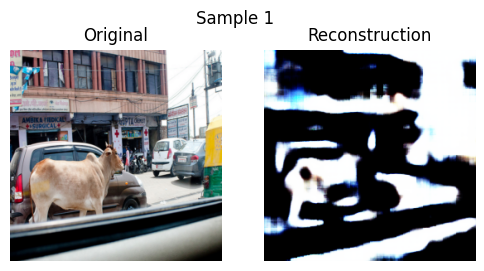

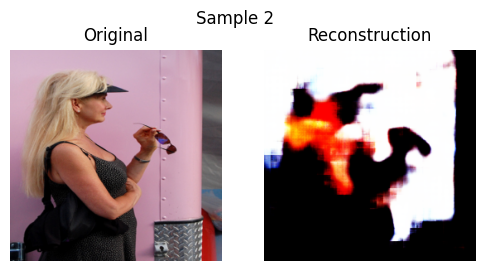

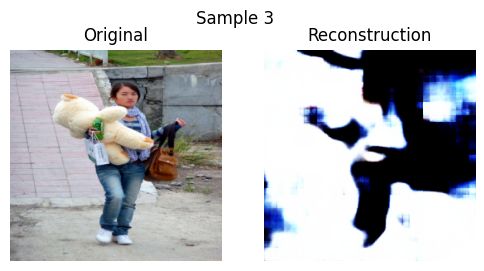

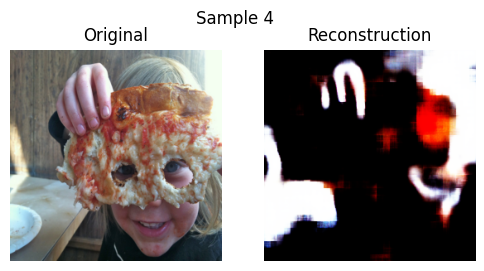

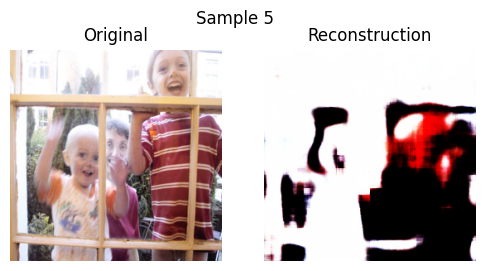

In [50]:
# --- View the first 5 samples from the test set ---
num_samples_to_view = 5
sample_count = 0

for images, input_ids, attention_mask in test_loader:
    if sample_count >= num_samples_to_view:
        break # Stop after viewing the desired number of samples
    
    # Only process the first image in the batch for visualization
    
    images = images.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # --- Encode text and image, then decode ---
    with torch.no_grad():
        bert_out = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = bert_out.last_hidden_state.to(device)
        mu, logvar = encoder(images)
        z = reparameterize(mu, logvar)
        recon = decoder(z, text_embedding)

    # Denormalize Utility (Place this definition above the loop if possible)
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor.cpu() * std + mean
        return torch.clip(tensor, 0, 1)

    # Convert first sample to PIL (B=0)
    original_display_tensor = images[0].cpu().clone() 
    denormalized_orig_tensor = denormalize(original_display_tensor)
    orig_img = to_pil(denormalized_orig_tensor)
    recon_img = to_pil(torch.clip(recon[0].cpu(), 0, 1))

    # Show results
    plt.figure(figsize=(6,3))
    plt.suptitle(f"Sample {sample_count + 1}")
    plt.subplot(1,2,1); plt.title("Original"); plt.axis("off"); plt.imshow(orig_img)
    plt.subplot(1,2,2); plt.title("Reconstruction"); plt.axis("off"); plt.imshow(recon_img)
    plt.show()
    
    sample_count += 1

## Latent Dimension-8, Regularized KL divergence, L1 Loss

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = VAEEncoder(latent_dim = 8).to(device)
decoder = TextConditionedDecoder(latent_dim= 8).to(device)
bert_model.eval().to(device)  # freeze BERT for now

optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=2e-4)

In [56]:
torch.cuda.empty_cache()

In [57]:
num_epochs = 5

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, input_ids, attention_mask = batch  # images: (B,3,256,256), text_embeddings: (B, max_len, 768)
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            text_embedding = outputs.last_hidden_state
            text_embedding = text_embedding.to(device)
            
        #print(text_embeddings.shape)
        optimizer.zero_grad()

        # --- Encode image ---
        mu, logvar = encoder(images)
        z = reparameterize(mu, logvar)  # (B, latent_dim, H, W)
        #print(z.shape)
        # --- Decode with text conditioning ---
        recon = decoder(z, text_embedding)  # output: (B,3,256,256)

        # --- Compute Loss ---
        recon_loss = F.l1_loss(recon, images, reduction='mean')
        kld = kl_loss(mu, logvar, reduction='mean')
        
        beta = 0.001 

        loss = recon_loss + (beta * kld)        

        # --- Backprop ---
        loss.backward()
        optimizer.step()

        del images, input_ids, attention_mask, text_embedding, mu, logvar, z, recon, loss
        torch.cuda.empty_cache()

    print(f"Epoch {epoch} | Recon Loss: {recon_loss.item():.4f} | KL Loss: {kld.item():.4f}")


Epoch 0: 100%|██████████| 7476/7476 [16:21<00:00,  7.62it/s]  


Epoch 0 | Recon Loss: 0.6832 | KL Loss: 2.0876


Epoch 1: 100%|██████████| 7476/7476 [17:27<00:00,  7.14it/s]  


Epoch 1 | Recon Loss: 0.7058 | KL Loss: 2.0529


Epoch 2: 100%|██████████| 7476/7476 [16:11<00:00,  7.70it/s]  


Epoch 2 | Recon Loss: 0.6997 | KL Loss: 2.0201


Epoch 3: 100%|██████████| 7476/7476 [15:45<00:00,  7.91it/s]  


Epoch 3 | Recon Loss: 0.7080 | KL Loss: 1.9436


Epoch 4: 100%|██████████| 7476/7476 [17:20<00:00,  7.19it/s]  

Epoch 4 | Recon Loss: 0.7428 | KL Loss: 2.0519


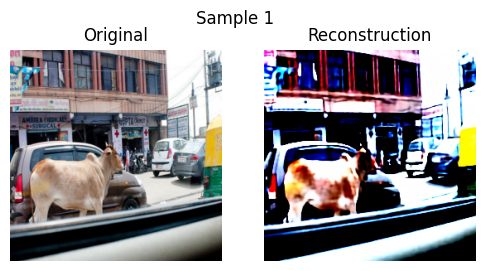

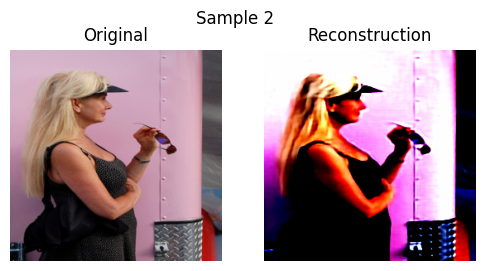

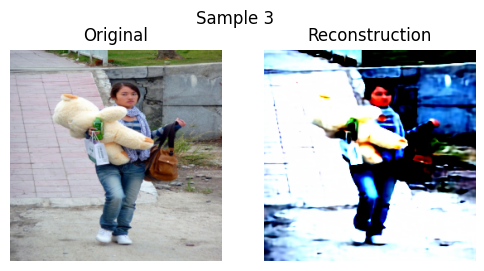

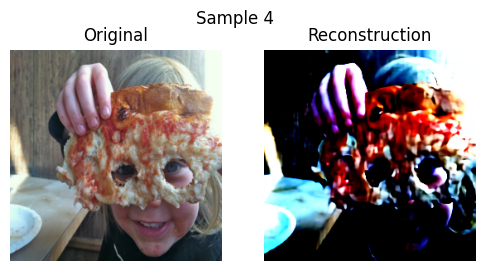

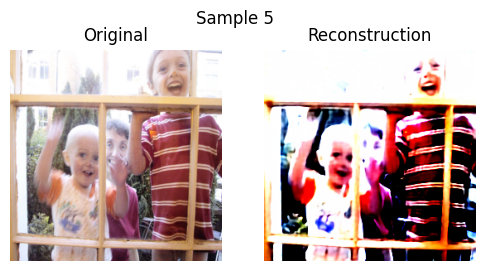

In [58]:
# --- View the first 5 samples from the test set ---
num_samples_to_view = 5
sample_count = 0

for images, input_ids, attention_mask in test_loader:
    if sample_count >= num_samples_to_view:
        break # Stop after viewing the desired number of samples
    
    # Only process the first image in the batch for visualization
    
    images = images.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # --- Encode text and image, then decode ---
    with torch.no_grad():
        bert_out = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = bert_out.last_hidden_state.to(device)
        mu, logvar = encoder(images)
        z = reparameterize(mu, logvar)
        recon = decoder(z, text_embedding)

    # Denormalize Utility (Place this definition above the loop if possible)
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor.cpu() * std + mean
        return torch.clip(tensor, 0, 1)

    # Convert first sample to PIL (B=0)
    original_display_tensor = images[0].cpu().clone() 
    denormalized_orig_tensor = denormalize(original_display_tensor)
    orig_img = to_pil(denormalized_orig_tensor)
    recon_img = to_pil(torch.clip(recon[0].cpu(), 0, 1))

    # Show results
    plt.figure(figsize=(6,3))
    plt.suptitle(f"Sample {sample_count + 1}")
    plt.subplot(1,2,1); plt.title("Original"); plt.axis("off"); plt.imshow(orig_img)
    plt.subplot(1,2,2); plt.title("Reconstruction"); plt.axis("off"); plt.imshow(recon_img)
    plt.show()
    
    sample_count += 1

### Inference Testing with Random Noise

--- Starting Text-to-Image Generation ---


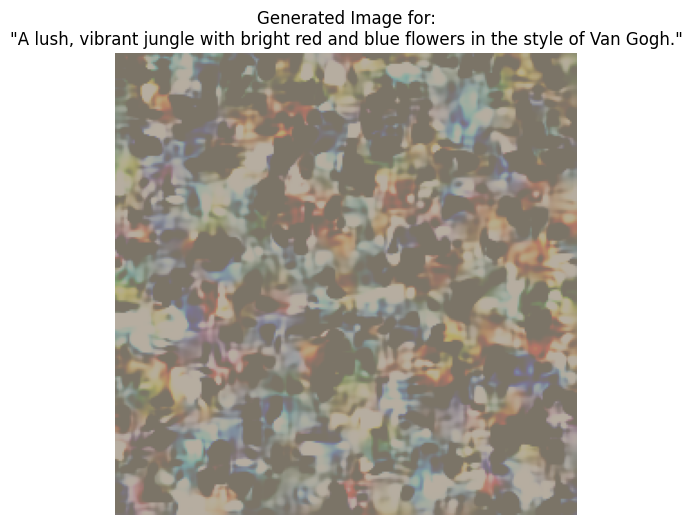

In [64]:
import torch
import matplotlib.pyplot as plt

import copy # For the denormalize function

# --- 0. Configuration and Utilities ---
# IMPORTANT: These must match your final training setup
latent_dim = 8   # Use the final latent dimension you settled on (e.g., 16)
latent_H = 32     # VAE output resolution (256 / 8)
latent_W = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
MAX_LEN = 77      # Use the max sequence length from your training setup
to_pil = ToPILImage()

# Denormalization function
def denormalize(tensor):
    # Ensure mean/std are tensors on the correct device for the calculation
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    tensor = tensor.cpu() * std + mean
    return torch.clip(tensor, 0, 1)

# Set models to evaluation mode
encoder.eval()
decoder.eval()
bert_model.eval()

# Assuming your 'tokenizer' object is available (e.g., from Hugging Face)

# --- 1. Generation Function ---
def generate_image_from_text(prompt, tokenizer, bert_model, decoder, device):
    
    # 1. Encode the Text Prompt
    inputs = tokenizer(
        prompt, 
        padding='max_length', 
        truncation=True, 
        max_length=MAX_LEN, 
        return_tensors="pt"
    )
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        bert_out = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        # Get the contextual text embedding
        text_embedding = bert_out.last_hidden_state.to(device)
        # text_embedding shape: (1, seq_len, 768)

        # 2. Sample from the Latent Prior N(0, 1)
        # This replaces the VAE encoder output. It is the random seed for the image.
        z_prior = torch.randn(1, latent_dim, latent_H, latent_W).to(device)
        
        # 3. Decode with Text Conditioning
        # The decoder converts the random noise (z_prior) into an image, guided by the text.
        generated_image_tensor = decoder(z_prior, text_embedding)
        # generated_image_tensor shape: (1, 3, 256, 256)

    # 4. Denormalize and Visualize
    image_to_display = denormalize(generated_image_tensor[0].cpu())
    final_image_pil = to_pil(image_to_display)

    plt.figure(figsize=(6, 6))
    plt.title(f"Generated Image for:\n\"{prompt}\"")
    plt.imshow(final_image_pil)
    plt.axis("off")
    plt.show()

# --- 2. Test with your desired prompts ---
print("--- Starting Text-to-Image Generation ---")

prompt1 = "A boy sitting in a bench"
#generate_image_from_text(prompt1, tokenizer, bert_model, decoder, device)

prompt2 = "A lush, vibrant jungle with bright red and blue flowers in the style of Van Gogh."
generate_image_from_text(prompt2, tokenizer, bert_model, decoder, device)

# Encoder(Text + Image) --> Decoder (z, Text)
Injecting Random Noise for 30% of data for model to learn from text encodings

In [23]:
class CrossAttention(nn.Module):
    def __init__(self, dim, context_dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        
        self.query = nn.Linear(dim, dim)
        self.key   = nn.Linear(context_dim, dim)
        self.value = nn.Linear(context_dim, dim)
        self.proj  = nn.Linear(dim, dim)
        
    def forward(self, x, context):
        B, N, C = x.shape  # image tokens
        _, M, D = context.shape  # text tokens

        q = self.query(x)
        #print(q.shape, 'query shape')
        k = self.key(context)
        #print(k.shape, 'key shape')
        v = self.value(context)
        #print(v.shape, 'after value shape')

        q = q.view(B, N, self.num_heads, C//self.num_heads).transpose(1,2)
        k = k.view(B, M, self.num_heads, C//self.num_heads).transpose(1,2)
        v = v.view(B, M, self.num_heads, C//self.num_heads).transpose(1,2)
        #print(q.shape, k.shape, v.shape)
        attn = (q @ k.transpose(-2, -1)) / (C**0.5)
        attn = attn.softmax(dim=-1)
        #print(attn.shape, 'attention shape')
        out = attn @ v
        out = out.transpose(1,2).reshape(B, N, C)
        #print(out.shape,'out shape')
        return self.proj(out)

In [24]:
class JointVAEEncoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=8, hidden_dim=256, text_dim=768):
        super().__init__()
        # Image encoder
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim//2, 3, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dim//2),
            nn.SiLU(),
            nn.Conv2d(hidden_dim//2, hidden_dim, 3, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dim),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dim),
            nn.SiLU(),
        )

        # Cross attention to fuse image + text
        self.cross = CrossAttention(hidden_dim, text_dim)

        # Latent projections
        self.to_mu     = nn.Conv2d(hidden_dim, latent_dim, 3, padding=1)
        self.to_logvar = nn.Conv2d(hidden_dim, latent_dim, 3, padding=1)

    def forward(self, x, text_emb):
        B, _, H, W = x.shape
        x = self.conv(x)  # (B, hidden, H/8, W/8)
        B, C, h, w = x.shape
        x_tokens = x.flatten(2).transpose(1, 2)  # (B, hw, C)
        fused = x_tokens + self.cross(x_tokens, text_emb)
        fused = fused.transpose(1, 2).reshape(B, C, h, w)
        mu = self.to_mu(fused)
        logvar = self.to_logvar(fused)
        return mu, logvar

In [25]:
class TextConditionedDecoder(nn.Module):
    def __init__(self, latent_dim=8, hidden_dim=256, text_dim=768):
        super().__init__()

        self.initial_conv = nn.Conv2d(latent_dim, hidden_dim, 3, padding=1)

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, hidden_dim//2, kernel_size = 4, stride = 2, padding=1),
            nn.GroupNorm(8, hidden_dim//2),
            nn.SiLU(),
        )
        self.cross1 = CrossAttention(hidden_dim, text_dim)

        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim//2, hidden_dim//4, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dim//4),
            nn.SiLU(),
        )
        self.cross2 = CrossAttention(hidden_dim//2, text_dim)

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim//4, hidden_dim//8, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dim//8),
            nn.SiLU(),
        )
        
        self.cross3 = CrossAttention(hidden_dim//4, text_dim)

        self.final_conv = nn.Conv2d(hidden_dim//8, 3, 3, padding=1)

    def forward(self, z, text_emb):
        # z: (B, 4, H/8, W/8)
        B, C, H, W = z.shape
        x = self.initial_conv(z)
        #print(x.shape,'after initial conv')
        # Tokenize spatial map for cross-attention
        x_tokens = x.flatten(2).transpose(1,2)  # (B, HW, C)
        #print(x_tokens.shape, 'after flatten')
        x_tokens = x_tokens + self.cross1(x_tokens, text_emb)
        #print(x_tokens.shape, 'after one cross')
        x = x_tokens.transpose(1,2).reshape(B, -1, H, W)
        #print(x.shape, 'after transpose and reshape')
        x = self.block1(x)
        #print(x.shape, 'after block1')

        x_tokens = x.flatten(2).transpose(1,2)
        #print(x_tokens.shape, 'after flatten 2')
        x_tokens = x_tokens + self.cross2(x_tokens, text_emb)
        #print(x_tokens.shape, 'after cross2')
        x = x_tokens.transpose(1,2).reshape(B, -1, H*2, W*2)
        #print(x.shape, 'after transpose and reshape')
        x = self.block2(x)
        #print(x.shape,'after block2')


        H, W = x.shape[2], x.shape[3]
        x_tokens = x.flatten(2).transpose(1,2)
        x_tokens = x_tokens + self.cross3(x_tokens, text_emb)
        x = x_tokens.transpose(1,2).reshape(B, -1, H, W)
        x = self.block3(x)  # -> 256x256
        #print(x.shape, 'final block shape')
        return torch.sigmoid(self.final_conv(x))


In [26]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def kl_loss(mu, logvar):
    return (-0.5 * (1 + logvar - mu.pow(2) - logvar.exp())).mean()

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = JointVAEEncoder().to(device)
decoder = TextConditionedDecoder().to(device)
bert_model.eval().to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [28]:
optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=2e-4)

In [29]:
INFERENCE_PROMPT = "a cat sitting on a sofa"
# Ensure the tokenizer and BERT model are available globally or passed in
with torch.no_grad():
    tokens = tokenizer([INFERENCE_PROMPT], return_tensors="pt", padding=True).to(device)
    # The text embedding for the fixed inference prompt
    INFERENCE_TEXT_EMB = bert_model(**tokens).last_hidden_state
    
# Fixed latent shape for the sample (B=1, latent_dim=8, H=32, W=32)
# This z is sampled once and used every epoch to track deterministic progress
# Alternatively, sample a new z every time if you want variability
INFERENCE_Z = torch.randn(1, 8, 32, 32).to(device)

In [30]:
def generate_and_plot_image(decoder_model, text_emb, z, epoch, prompt):
    """Generates an image from latent z and text embedding, and plots it."""
    decoder_model.eval() # Set decoder to evaluation mode
    
    with torch.no_grad():
        # 1. Generate the image
        gen_img_tensor = decoder_model(z, text_emb)
        
        # 2. Convert to CPU and remove the batch dimension (1, C, H, W) -> (C, H, W)
        gen_img_tensor = gen_img_tensor.cpu().squeeze(0)
        
        # 3. Convert (C, H, W) tensor to (H, W, C) NumPy array for plotting
        gen_img_np = gen_img_tensor.permute(1, 2, 0).numpy() # <--- This line defines gen_img_np
        
        # 4. Plotting the image
        plt.figure(figsize=(4, 4))
        plt.imshow(gen_img_np)
        plt.title(f"Epoch {epoch} | Prompt: '{prompt}'")
        plt.axis('off') # Hide axis ticks and labels
        plt.show() # Display the plot

    decoder_model.train() # Set decoder back to training mode

In [31]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 478433
Val samples: 59804
Test samples: 59805


In [32]:
#del images, input_ids, attention_mask, text_embedding, mu, logvar, z, recon, loss
torch.cuda.empty_cache()

Epoch 0: 100%|██████████| 3738/3738 [15:32<00:00,  4.01it/s]


Epoch 0 | Recon Loss: 0.7512 | KL Loss: 0.8462 | Current Beta: 0.0100


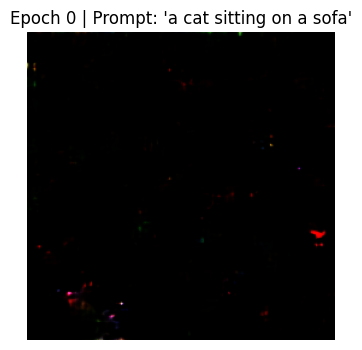

Epoch 1: 100%|██████████| 3738/3738 [15:06<00:00,  4.12it/s]

Epoch 1 | Recon Loss: 1.0195 | KL Loss: 0.5341 | Current Beta: 0.0200


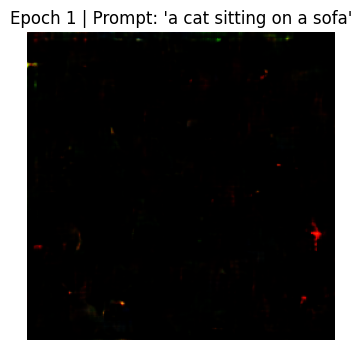

Epoch 2: 100%|██████████| 3738/3738 [14:53<00:00,  4.18it/s] 


Epoch 2 | Recon Loss: 0.7692 | KL Loss: 0.4277 | Current Beta: 0.0300


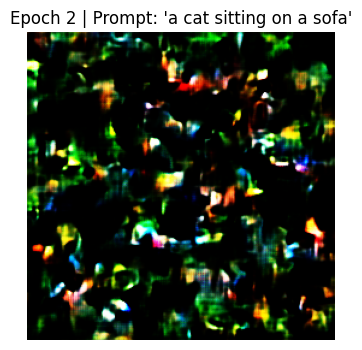

Epoch 3: 100%|██████████| 3738/3738 [14:52<00:00,  4.19it/s]


Epoch 3 | Recon Loss: 0.7372 | KL Loss: 0.3509 | Current Beta: 0.0400


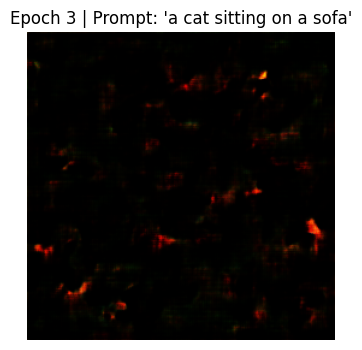

Epoch 4: 100%|██████████| 3738/3738 [14:43<00:00,  4.23it/s]


Epoch 4 | Recon Loss: 1.0451 | KL Loss: 0.2869 | Current Beta: 0.0500


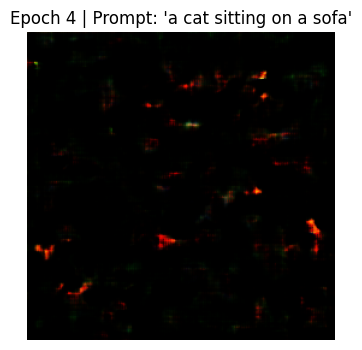

Epoch 5: 100%|██████████| 3738/3738 [14:46<00:00,  4.22it/s]


Epoch 5 | Recon Loss: 0.9846 | KL Loss: 0.2969 | Current Beta: 0.0500


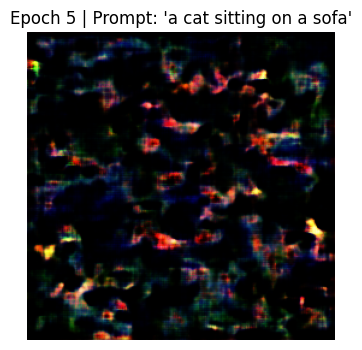

Epoch 6: 100%|██████████| 3738/3738 [14:48<00:00,  4.21it/s]


Epoch 6 | Recon Loss: 1.0199 | KL Loss: 0.2470 | Current Beta: 0.0500


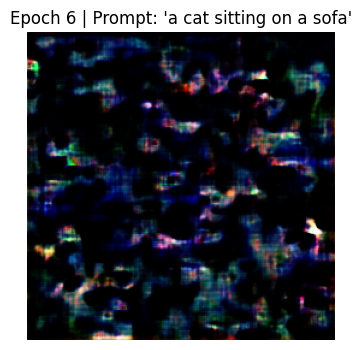

Epoch 7: 100%|██████████| 3738/3738 [14:37<00:00,  4.26it/s]


Epoch 7 | Recon Loss: 0.7688 | KL Loss: 0.2783 | Current Beta: 0.0500


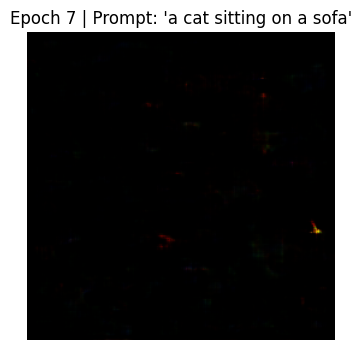

Epoch 8: 100%|██████████| 3738/3738 [14:35<00:00,  4.27it/s]


Epoch 8 | Recon Loss: 1.0450 | KL Loss: 0.2417 | Current Beta: 0.0500


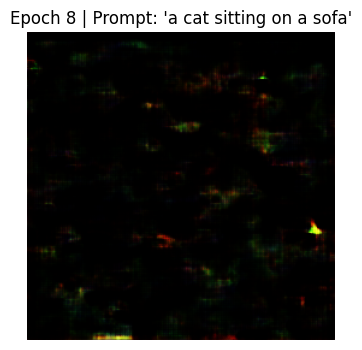

Epoch 9: 100%|██████████| 3738/3738 [14:40<00:00,  4.24it/s]


Epoch 9 | Recon Loss: 1.0054 | KL Loss: 0.2936 | Current Beta: 0.0500


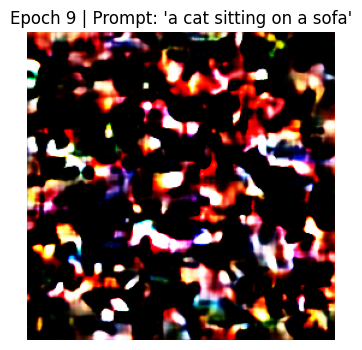

Epoch 10:   7%|▋         | 249/3738 [00:59<13:03,  4.45it/s]

In [ ]:
# ... (outside the epoch loop - define BETA_TARGET, WARMUP_STEPS, current_step) ...

BETA_TARGET = 0.05
# Example: 7476 steps/epoch * 5 epochs = 37380 steps
WARMUP_EPOCHS = 5
WARMUP_STEPS = len(train_loader) * WARMUP_EPOCHS 
current_step = 0

num_epochs = 15

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        
        # --- 🚀 KL Annealing Calculation ---
        anneal_factor = min(current_step / WARMUP_STEPS, 1.0) 
        beta = BETA_TARGET * anneal_factor
        current_step += 1
        # ------------------------------------

        images, input_ids, attention_mask = batch
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            text_embedding = outputs.last_hidden_state
            
        optimizer.zero_grad()

        # --- Encode image ---
        mu, logvar = encoder(images, text_embedding)
        z = reparameterize(mu, logvar)
        if torch.rand(1).item() < 0.3:
            z = torch.randn_like(z)
            
        # --- Decode with text conditioning ---
        recon = decoder(z, text_embedding)

        # --- Compute Loss ---
        recon_loss = F.l1_loss(recon, images, reduction='mean')
        kld = kl_loss(mu, logvar)
        
        loss = recon_loss + (beta * kld) 
        
        # --- Backprop ---
        loss.backward()
        optimizer.step()

        # Clean up memory
        del images, input_ids, attention_mask, text_embedding, mu, logvar, z, recon, loss
        torch.cuda.empty_cache()

    # --- Print Epoch Results and Current Beta ---
    print(f"Epoch {epoch} | Recon Loss: {recon_loss.item():.4f} | KL Loss: {kld.item():.4f} | Current Beta: {beta:.4f}")

    # --- 🖼️ RUN INFERENCE AND SAVE IMAGE ---
    # Use the function to generate a sample image after the epoch finishes
    generate_and_plot_image(
        decoder, 
        INFERENCE_TEXT_EMB, 
        INFERENCE_Z, 
        epoch, 
        INFERENCE_PROMPT
    )

In [30]:
to_pil = ToPILImage()

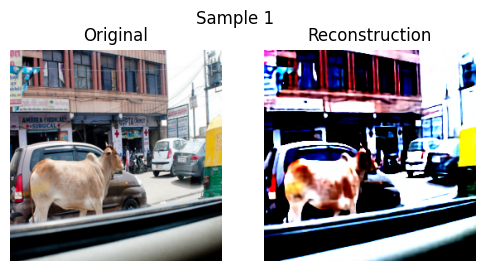

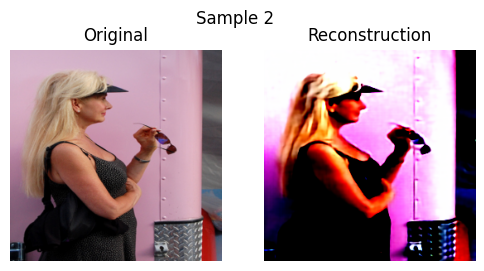

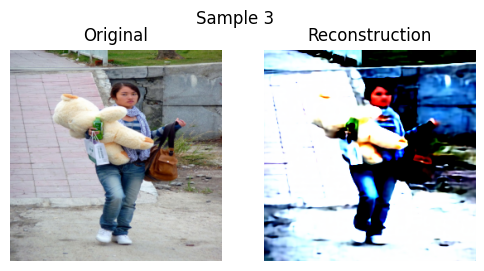

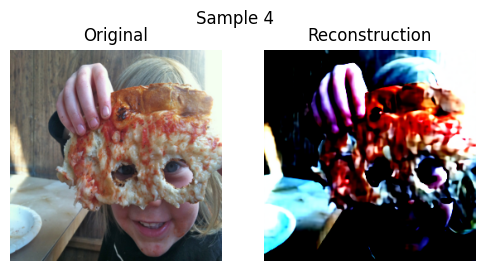

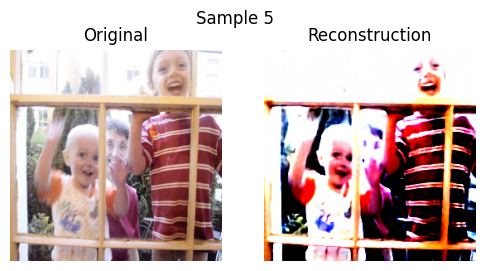

In [31]:
# --- View the first 5 samples from the test set ---
num_samples_to_view = 5
sample_count = 0

for images, input_ids, attention_mask in test_loader:
    if sample_count >= num_samples_to_view:
        break # Stop after viewing the desired number of samples
    
    # Only process the first image in the batch for visualization
    
    images = images.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # --- Encode text and image, then decode ---
    with torch.no_grad():
        bert_out = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = bert_out.last_hidden_state.to(device)
        mu, logvar = encoder(images, text_embedding)
        z = reparameterize(mu, logvar)
        recon = decoder(z, text_embedding)

    # Denormalize Utility (Place this definition above the loop if possible)
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor.cpu() * std + mean
        return torch.clip(tensor, 0, 1)

    # Convert first sample to PIL (B=0)
    original_display_tensor = images[0].cpu().clone() 
    denormalized_orig_tensor = denormalize(original_display_tensor)
    orig_img = to_pil(denormalized_orig_tensor)
    recon_img = to_pil(torch.clip(recon[0].cpu(), 0, 1))

    # Show results
    plt.figure(figsize=(6,3))
    plt.suptitle(f"Sample {sample_count + 1}")
    plt.subplot(1,2,1); plt.title("Original"); plt.axis("off"); plt.imshow(orig_img)
    plt.subplot(1,2,2); plt.title("Reconstruction"); plt.axis("off"); plt.imshow(recon_img)
    plt.show()
    
    sample_count += 1

In [39]:
with torch.no_grad():
    text = ["A very clean and well decorated empty bathroom"]
    tokens = tokenizer(text, return_tensors="pt", padding=True).to(device)
    text_emb = bert_model(**tokens).last_hidden_state
    z = torch.randn(1, 8, 32, 32).to(device)  # sample from N(0,1)
    gen_img = decoder(z, text_emb)


In [40]:
gen_img.shape

torch.Size([1, 3, 256, 256])

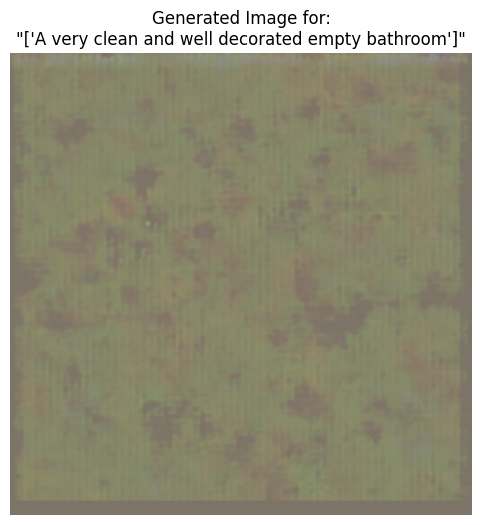

In [41]:
image_to_display = denormalize(gen_img[0].cpu())
final_image_pil = to_pil(image_to_display)
plt.figure(figsize=(6, 6))
plt.title(f"Generated Image for:\n\"{text}\"")
plt.imshow(final_image_pil)
plt.axis("off")
plt.show()

In [ ]:
# Define paths
encoder_path = parent_directory + "/models/encoder.pth"
decoder_path = parent_directory + "/models/decoder.pth"
optimizer_path = parent_directory + "/models/optimizer.pth"

# Save models
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)
torch.save(optimizer.state_dict(), optimizer_path)

print("Models and optimizer saved successfully!")